# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Это поможет сделать систему рекоммендаций эффективнее - у разных возрастных категорий разные потребности. А также позволит отслеживать возможные ошибки кассиров при продаже алкоголя.

**Цель работы:**  
Создать модель предсказания возраста человека по фотографии этого человека.  
Метрика качества - **MAE**. Она должна быть не выше 8.  

**Ход работы**
1. Импорт данных
2. Анализ данных
3. Обучение модели

## Исследовательский анализ данных

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

Загружаем данные, знакомимся с ними

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В датасете название файла с фотографии человека и возраст человека (наш целевой признак)

In [4]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
data_kids = data.query('real_age <= 20')['real_age']
data_adult = data.query('20 < real_age <= 60')['real_age']
data_elderly = data.query('60 < real_age')['real_age']

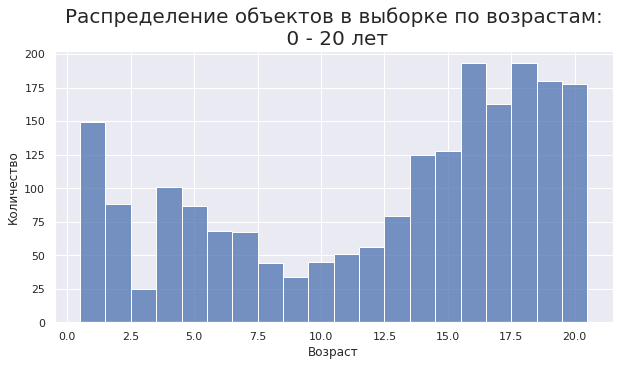

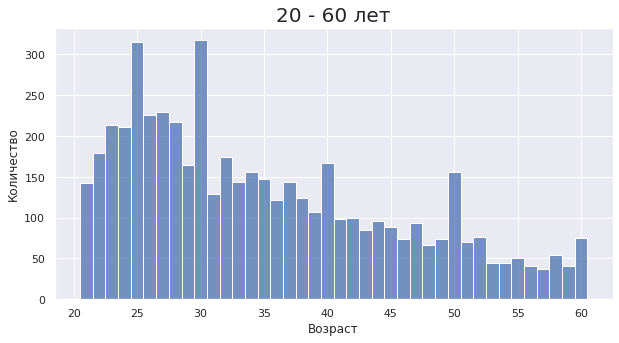

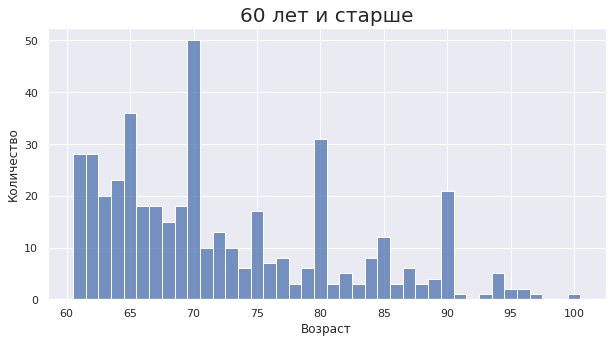

In [6]:
sns.set_theme()
plt.figure(figsize=(10, 5))
sns.histplot(data_kids, discrete=True)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение объектов в выборке по возрастам:\n 0 - 20 лет', fontsize=20)
plt.show()
plt.figure(figsize=(10, 5))
ax = sns.histplot(data_adult, discrete=True)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('20 - 60 лет', fontsize=20)
plt.show()
plt.figure(figsize=(10, 5))
ax = sns.histplot(data_elderly, discrete=True)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('60 лет и старше', fontsize=20)
plt.show()

Посмотрим на несколько фотографий из датасета (наших признаков)

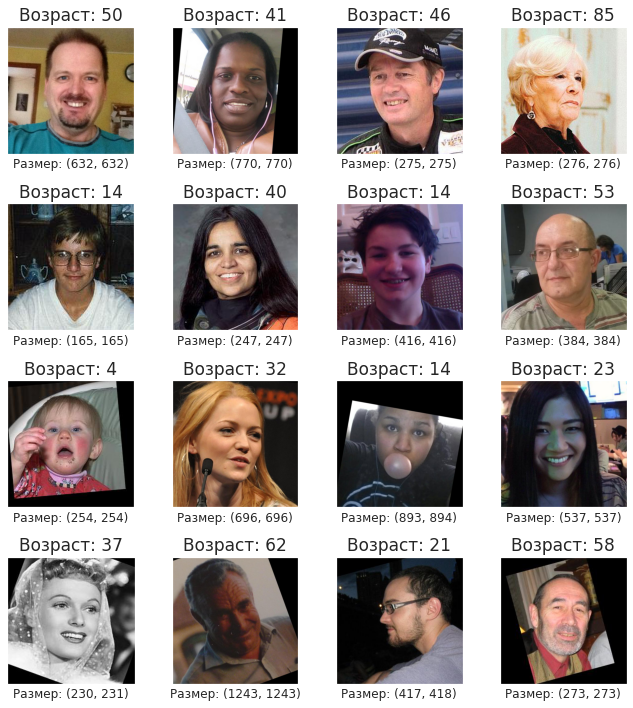

In [37]:
samples = data.sample(16, random_state=12345).values

for i in range(len(samples)):
    samples[i][0] = np.array(Image.open(
            '/datasets/faces/final_files/'+samples[i][0]))

fig = plt.figure(figsize=(10,10))
for i in range(len(samples)):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(samples[i][0])
    plt.title(label='Возраст: ' + str(samples[i][1]), fontsize=17)
    plt.xlabel(str(samples[i][0].shape[:2]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Результаты анализа выборки:**  
* В датасете фотографии людей разных возрастов распределены неравномерно:  
 >Преобладают фотографии с возрастами от 15 до 50 лет. Также, есть небольшой пик фотографий с возрастами от 0 до 3 лет. 
 
 >Еще, на гистограммах видны аномальные пики в районах "круглых" возрастов(25, 30...). Одна из возможных причин - желание взрослых людей округлить свой возраст в меньшую сторону. Этим же можно объяснить отсутсвие таких пиков для возрастов 20 и меньше.

* Судя по случайным 12 семплам изображений из датасет достаточно разнообразен - представлены люди разного гендера и разных национальностей

## Обучение модели

Код для обучения модели c спользованием библиотеки tensorflow:

```python

import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#загрузка тренировочной выборки
def load_train(path):
  df = pd.read_csv(path + '/labels.csv')

  train_datagen = ImageDataGenerator(
      rescale = 1 / 255,
      validation_split = 0.25,
      horizontal_flip = True,
      rotation_range=10)

  train_gen_flow = train_datagen.flow_from_dataframe(
      df,
      directory = path + '/final_files',
      x_col = 'file_name',
      y_col = 'real_age',
      target_size = (224, 224),
      class_mode = 'raw',
      batch_size = 32,
      shuffle = True,
      seed = 12345,
      subset = 'training'
  )
  return train_gen_flow

#загрузка тестовой выборки
def load_test(path):
  df = pd.read_csv(path + '/labels.csv')

  test_datagen = ImageDataGenerator(
      rescale = 1 / 255,
      validation_split = 0.25)

  test_gen_flow = test_datagen.flow_from_dataframe(
      df,
      directory = path + '/final_files',
      x_col = 'file_name',
      y_col = 'real_age',
      target_size = (224, 224),
      class_mode = 'raw',
      batch_size = 32,
      shuffle = True,
      seed = 12345,
      subset = 'validation'
  )
  return test_gen_flow

#инициализация модели
def create_model(input_shape):
  optimizer = Adam(lr = 0.0001)
  backbone = ResNet50(
      input_shape = input_shape,
      weights = 'imagenet',
      include_top = False
  )
  model = Sequential()
  model.add(backbone)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1, activation = 'relu'))
  model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae'])
  return model

#обучение модели
def train_model(model, train_data, test_data, batch_size = None, epochs = 7, steps_per_epoch = None, validation_steps = None):
  model.fit(
      train_data,
      validation_data = test_data,
      batch_size = batch_size,
      epochs = epochs,
      steps_per_epoch = steps_per_epoch,
      validation_steps = validation_steps,
      verbose = 2
      )
  return model


```

---
---
Результат обучения модели:

```
Train for 178 steps, validate for 60 steps
Epoch 1/7
178/178 - 110s - loss: 261.1952 - mae: 11.3561 - val_loss: 1066.0787 - val_mae: 28.0448
Epoch 2/7
178/178 - 87s - loss: 84.8389 - mae: 6.9447 - val_loss: 941.2320 - val_mae: 25.8508
Epoch 3/7
178/178 - 87s - loss: 60.2909 - mae: 5.9183 - val_loss: 268.0056 - val_mae: 11.8083
Epoch 4/7
178/178 - 87s - loss: 47.9182 - mae: 5.2702 - val_loss: 122.9252 - val_mae: 8.3811
Epoch 5/7
178/178 - 87s - loss: 37.3217 - mae: 4.6787 - val_loss: 75.9131 - val_mae: 6.5016
Epoch 6/7
178/178 - 87s - loss: 32.1087 - mae: 4.3638 - val_loss: 73.6378 - val_mae: 6.4628
Epoch 7/7
178/178 - 87s - loss: 24.7393 - mae: 3.8314 - val_loss: 72.4944 - val_mae: 6.2876


60/60 - 9s - loss: 72.4944 - mae: 6.2876
Test MAE: 6.2876

```

Получили итоговую метрику **MAE 6.2**

## Анализ обученной модели

Для задачи определения возраста человека по фотографии(задача регрессии) была выбрана модель архитектуры **ResNet50**. Датасет для обучения и валидации: 7.5 тысяч пар *фотография человека - возраст человека*.

После обучения получили модель с метрикой **MAE 6.2**, что соответсвует поставленной задаче.

 6.2 - это средняя ошибка модели, было бы интересно посмотреть в предсказании каких возрастов модель ошибается больше, а в предсказании каких меньше.